# Data Analysis

## Imports, Configurations & Dataloaders

In [1]:
import functools
import json
import time
from pathlib import Path

# Data analysis libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Display HTML in jupyer
from IPython.display import HTML, display

# Progress bar
from tqdm import tqdm

In [2]:
# Path to dirs
path_working: Path = Path()
path_db_dir: Path = path_working / ".." / "db" / "20221107-20221205"
path_db_files: list[Path] = sorted(path_db_dir.glob("*.parquet"))
path_assets: Path = path_working / "assets"

# Perform analysis on last X days
DAYS: int = 7
path_db_files: list[Path] = path_db_files[-DAYS:]

# Matplotlib style
plt.style.use("ggplot")

In [3]:
# Load cards
with open(path_assets / "cards.json") as f:
    cards: pd.DataFrame = pd.DataFrame(json.load(f))
func = lambda key: path_assets / "cards" / f"{key}.png"
cards["img"] = cards["key"].transform(func)


# Lazy load decks
def idecks(
    files: list[Path] = path_db_files,
    include: list[str] = [],
    exclude: list[str] = [],
) -> pd.DataFrame:
    """Generator that read parquet files and yield decks as DataFrame.

    :param files: list of parquet files to read.
    :param include: list of cards keys that are include in decks.
    :param exclude: list of cards keys that are exclude from decks.
    :yield: yield decks as DataFrame.
    """

    include = [cards["key"][cards["key"] == key].index[0] for key in include]
    exclude = [cards["key"][cards["key"] == key].index[0] for key in exclude]

    for file in tqdm(files):

        filters_team = [
            *[(f"('team', 'c{card}')", "=", True) for card in include],
            *[(f"('team', 'c{card}')", "=", False) for card in exclude],
        ]
        decks_team = pd.read_parquet(
            file,
            engine="pyarrow",
            columns=[f"('team', 'c{i}')" for i in np.arange(len(cards))],
            filters=filters_team if filters_team else None,
        )
        decks_team.columns = np.arange(len(cards))

        filters_team = [
            *[(f"('opponent', 'c{card}')", "=", True) for card in include],
            *[(f"('opponent', 'c{card}')", "=", False) for card in exclude],
        ]
        decks_opponent = pd.read_parquet(
            file,
            engine="pyarrow",
            columns=[f"('opponent', 'c{i}')" for i in np.arange(len(cards))],
            filters=filters_team if filters_team else None,
        )
        decks_opponent.columns = np.arange(len(cards))

        yield pd.concat([decks_team, decks_opponent], ignore_index=True, copy=False)

In [4]:
# Convert deck from np.ndarray to html
def deck_to_html(deck: np.ndarray) -> str:
    """Convert deck as array of bool to html with images.

    :param deck: deck as np.array of bool.
    :return: deck as html string containing images.
    """

    html = ""
    for i, card in enumerate(deck):
        if card:
            html += '<div style="display: inline-block;">'
            html += f'<img src={cards.iloc[i]["img"]} width="32">'
            html += "</div>"
    return html

## Cards

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.21s/it]


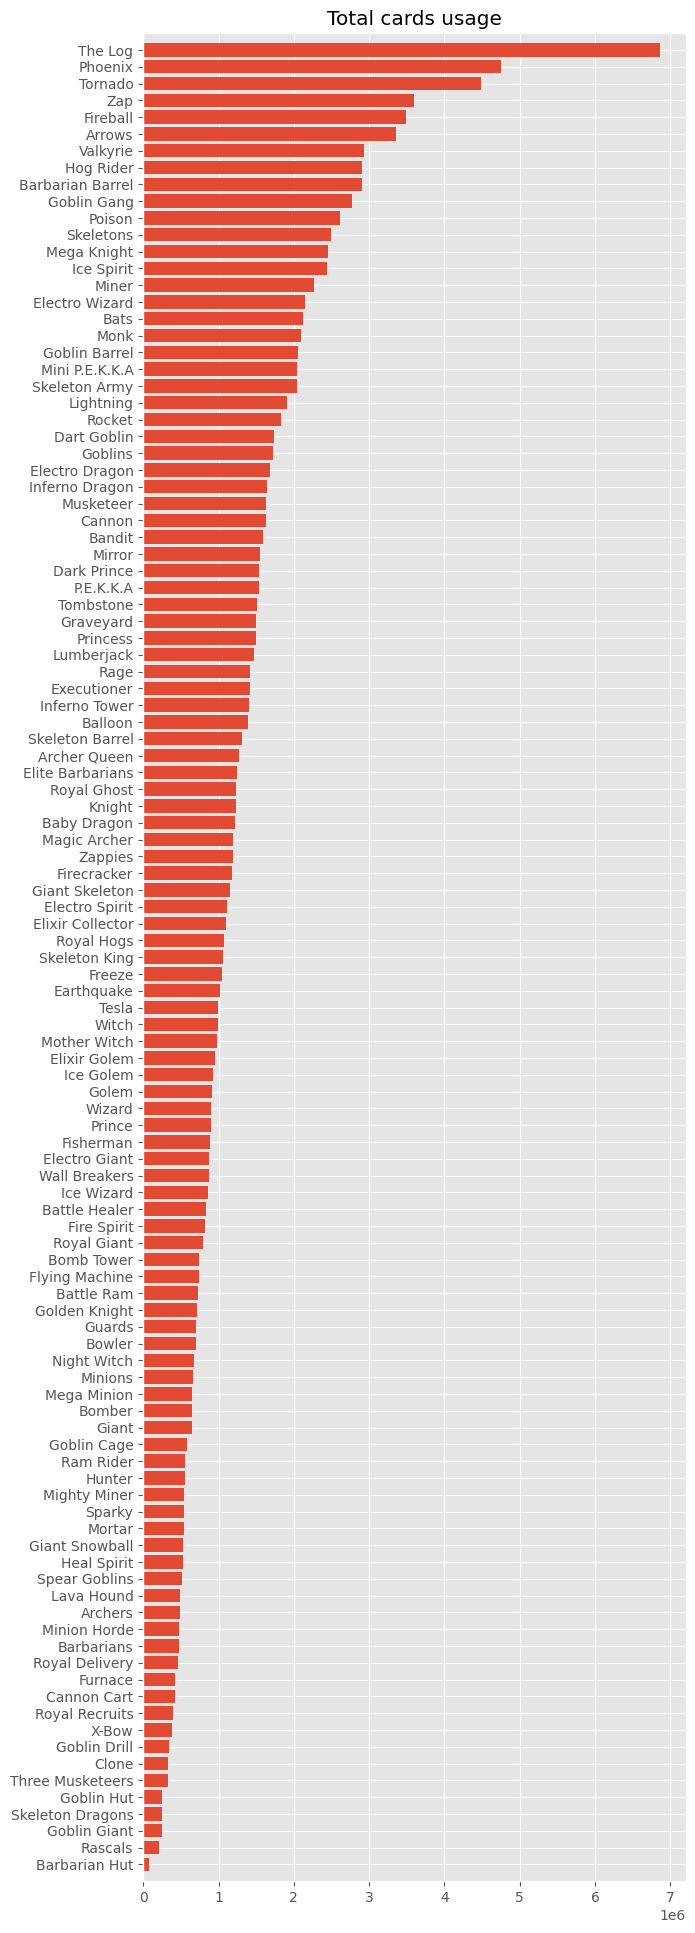

In [5]:
cards_usage = [decks.sum() for decks in idecks()]
cards_usage = np.array(cards_usage, dtype=int)

cards_usage_rel = cards_usage / cards_usage.sum(axis=1)[:, np.newaxis]

cards_usage_tot = cards_usage.sum(axis=0)
cards_usage_tot_sort_idx = np.argsort(cards_usage_tot)
cards_usage_tot_sort = cards_usage_tot[cards_usage_tot_sort_idx]

fig, ax = plt.subplots(figsize=(7, 24))
ax.barh(
    np.arange(len(cards)),
    cards_usage_tot_sort,
    align="center",
    tick_label=[cards.iloc[i]["name"] for i in cards_usage_tot_sort_idx],
)
ax.set_ylim(ymin=-1, ymax=len(cards))
ax.set_title("Total cards usage");

## Decks

In [6]:
decks_usage = [decks.value_counts()[:10] for decks in idecks()]

adder = functools.partial(pd.Series.add, fill_value=0)
decks_usage_tot = functools.reduce(adder, decks_usage).astype(int)
decks_usage_tot.sort_values(ascending=False, inplace=True)

decks_usage_tot_df = pd.DataFrame()
decks_usage_tot_df["count"] = decks_usage_tot.values
decks_usage_tot_df["deck"] = [deck_to_html(deck) for deck in decks_usage_tot.index]

display(HTML(decks_usage_tot_df.to_html(escape=False)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:59<00:00,  8.55s/it]


,count,deck
0,330766,
1,162332,
2,161370,
3,158061,
4,143657,
5,137101,
6,127280,
7,101265,
8,83148,
9,77405,
